# **Import libraries**

In [42]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import math

# **Load Car evaluation data**

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/19/data.csv')
print("Dataset Head:")
print(df.head())

Dataset Head:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


# Exploratory data analysis

## Data characteristics

In [25]:
# Display basic information about the dataset
print("Basic Information:")
df.info()

# Display the first few rows
print("\nFirst Five Rows:")
print(df.head())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Display column names
print("\nColumn Names:")
print(df.columns)

# Display unique values in each column
print("\nUnique Entries:")
for col in df:
    print(col)
    print(df[col].unique())
    print('\n')

# Display the frequency of each unique values in each column
print("\nFrequency of Unique Entries:")
for col in df:
    print(f"\nFrequency of values in {col}:")
    print(df[col].value_counts())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB

First Five Rows:
  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

Summary Statistics:
       buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      

## Visualize data

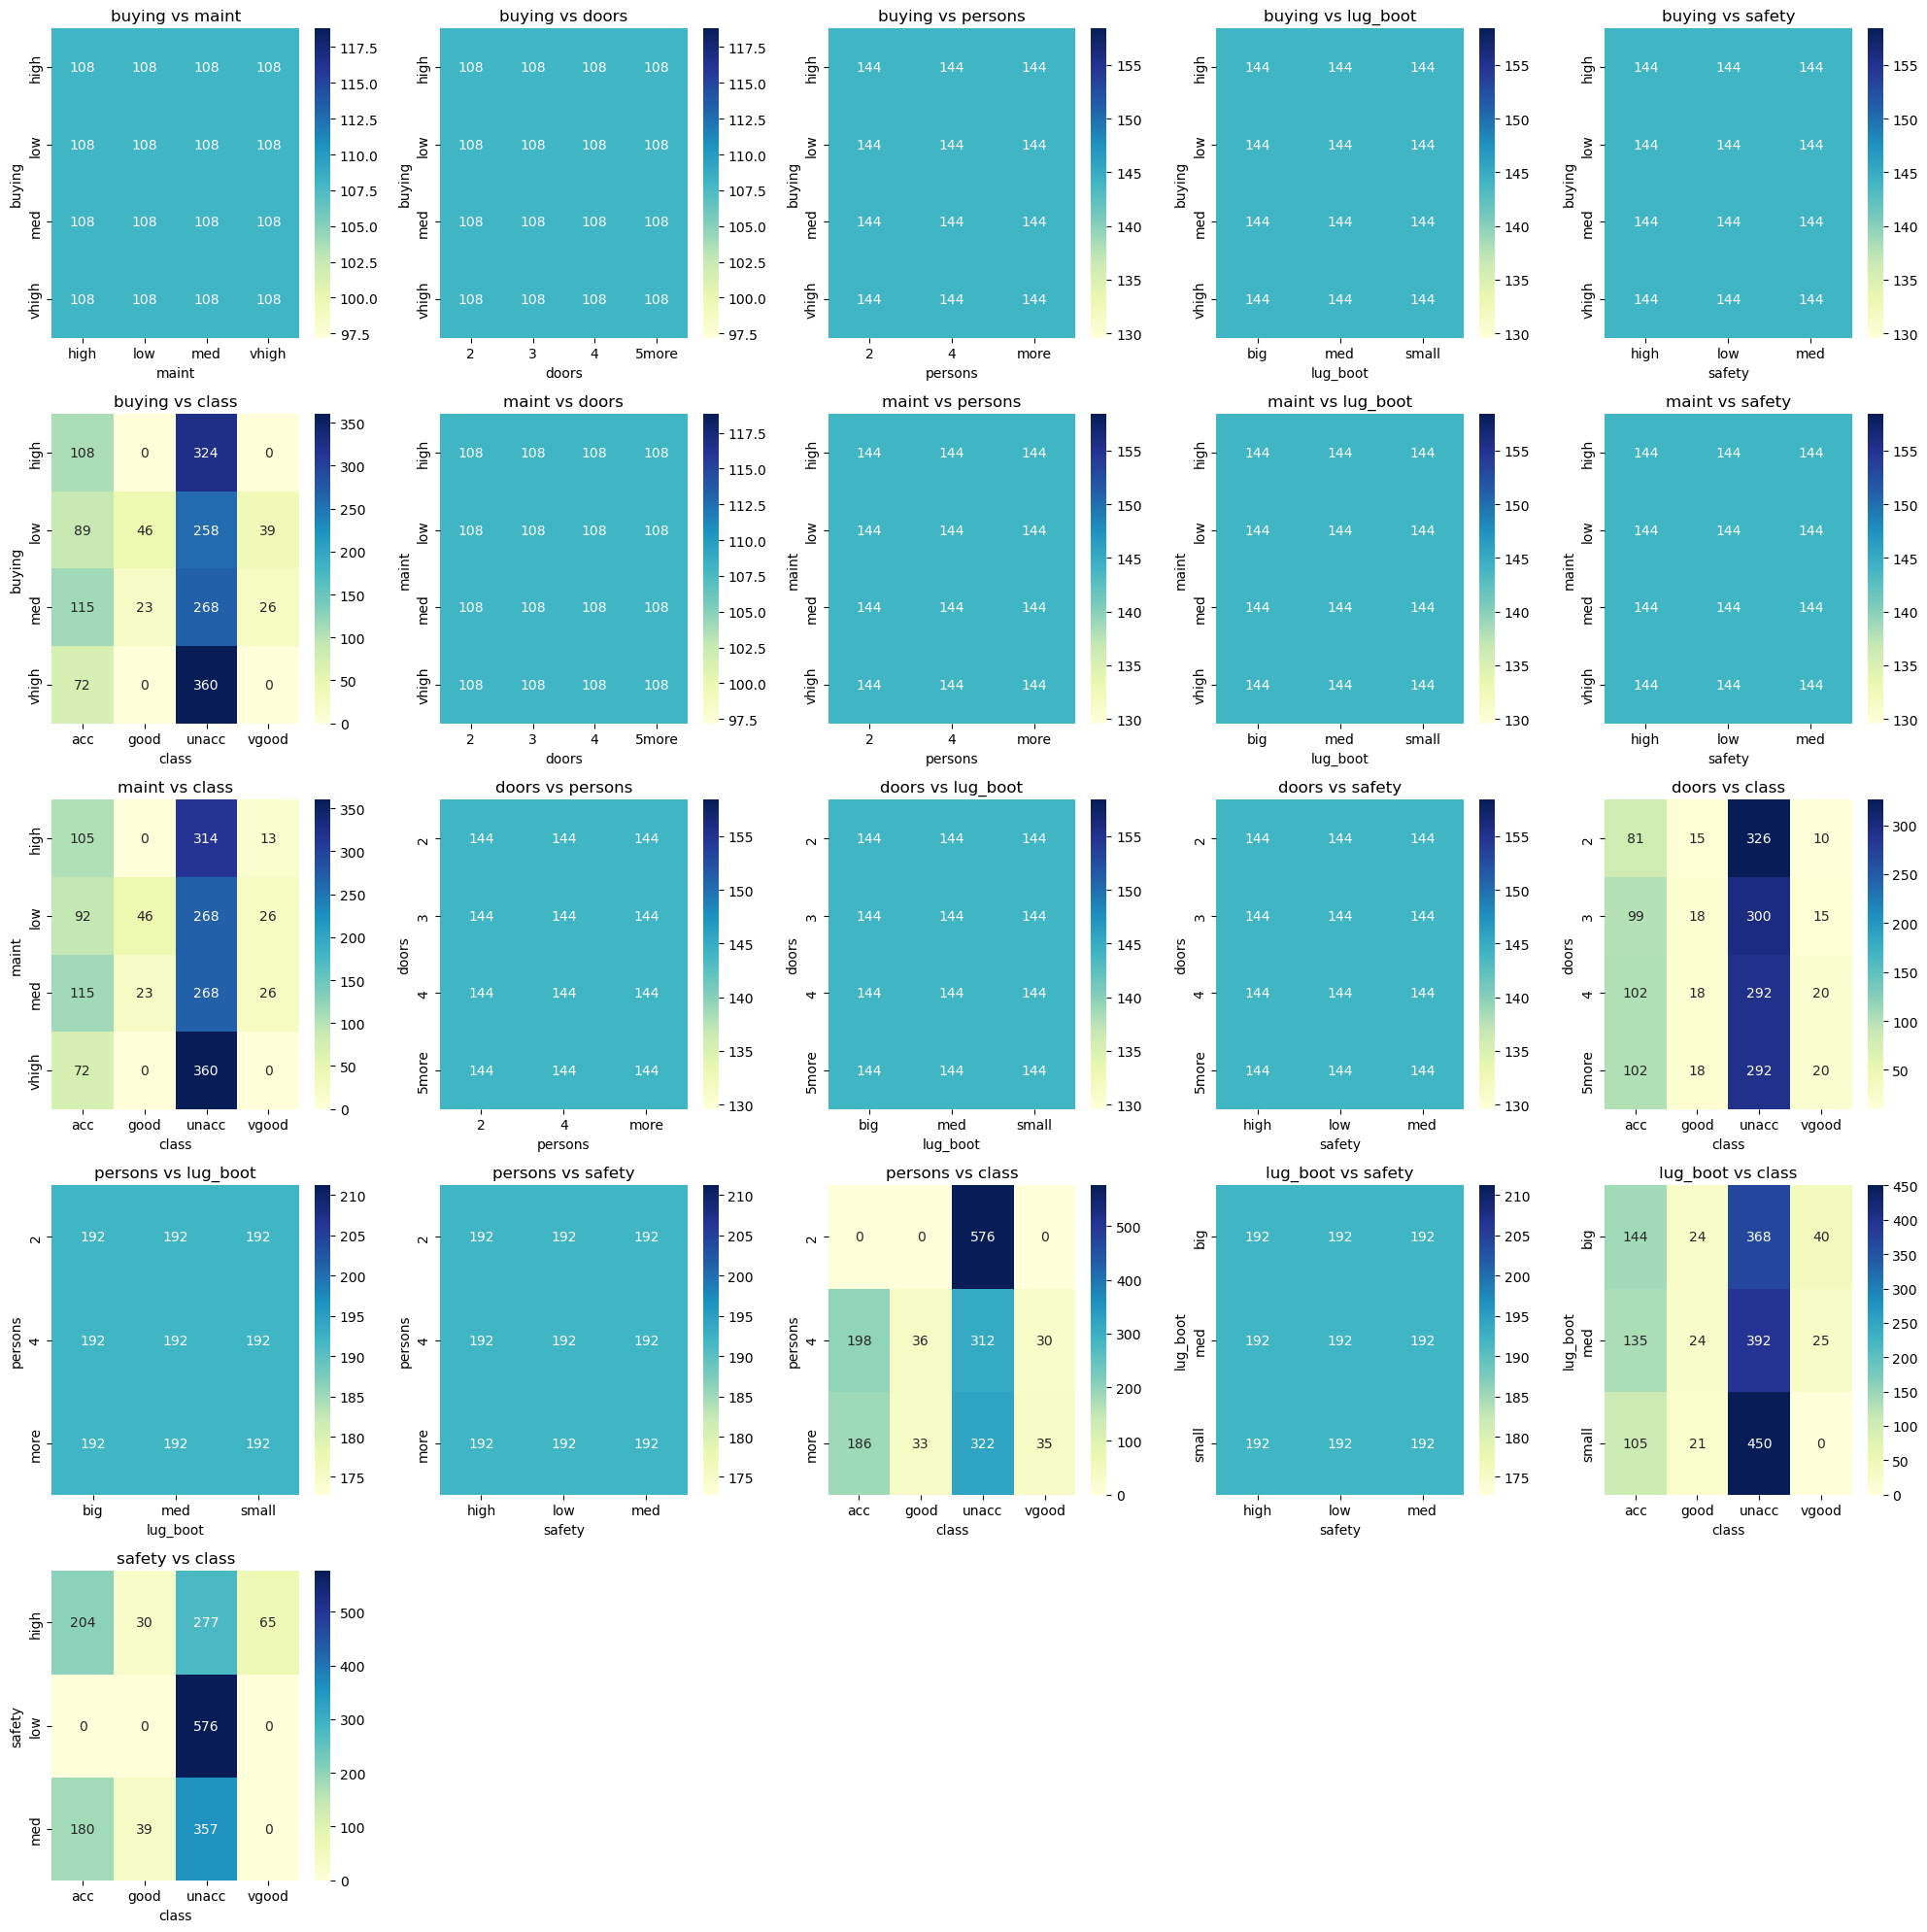

In [45]:
# Get all unique pairs of columns
columns = ["buying", "maint", "doors", "persons", "lug_boot", "safety", "class"]
col_pairs = list(itertools.combinations(df.columns, 2))
n_pairs = len(col_pairs)

# Set up a grid of subplots
n_cols = 5
n_rows = math.ceil(n_pairs / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, (col1, col2) in enumerate(col_pairs):
    # Create a cross-tabulation (joint frequency) for the two columns
    ct = pd.crosstab(df[col1], df[col2])
    
    # Plot the heatmap with annotation
    sns.heatmap(ct, annot=True, fmt="d", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f"{col1} vs {col2}")
    axes[i].set_xlabel(col2)
    axes[i].set_ylabel(col1)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()